# Analysing the calibration of the ConvNext_BS model on BirdSet

In [2]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8")
# ---- Figure sizing helpers (SCITEPRESS columns) ----
CM = 1/2.54
COL_W = 7.5 * CM        # single column = 7.5 cm
TWO_COL_W = 15.8 * CM   # two columns = 2*7.5 + 0.8 cm gap

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman", "STIXGeneral"],
    "mathtext.fontset": "stix",
    "mathtext.rm": "STIXGeneral",
    "mathtext.it": "STIXGeneral:italic",
    "mathtext.bf": "STIXGeneral:bold",

    # --- Larger fonts for small figure widths ---
    "font.size": 14,            # base size
    "axes.labelsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "axes.titlesize": 14,

    # --- Styling ---
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "legend.frameon": False,

    # --- Vector fonts ---
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    "figure.autolayout": True,
})

In [3]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_data

data, predictions, targets, valid_keys = load_data("/workspace/logs/predictions/convnext_bs", load_logits=True)

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Loaded data with 23756 samples
Predictions shape: torch.Size([23756, 9736])
Targets shape: torch.Size([23756, 9736])
Loaded data with 205200 samples
Predictions shape: torch.Size([205200, 9736])
Targets shape: torch.Size([205200, 9736])
Loaded data with 36637 samples
Predictions shape: torch.Size([36637, 9736])
Targets shape: torch.Size([36637, 9736])


In [4]:
data["NBP"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color', 'metrics', 'logits'])

## Global - all labels incl. non present target labels

In [5]:
from uncertainbird.utils.plotting import print_metrics

# metrics = print_metrics(predictions, targets)

In [6]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

# plot_reliability_diagram(
#     predictions,
#     targets,
#     n_bins=10,
#     title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
# )

## Global - only classes present in the target labels

```python

In [7]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 411
Number of classes with atleast 5 samples in targets: 372


In [8]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

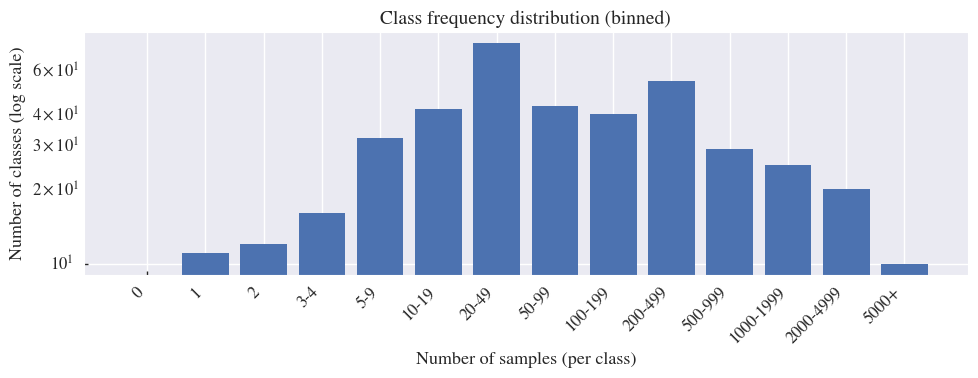

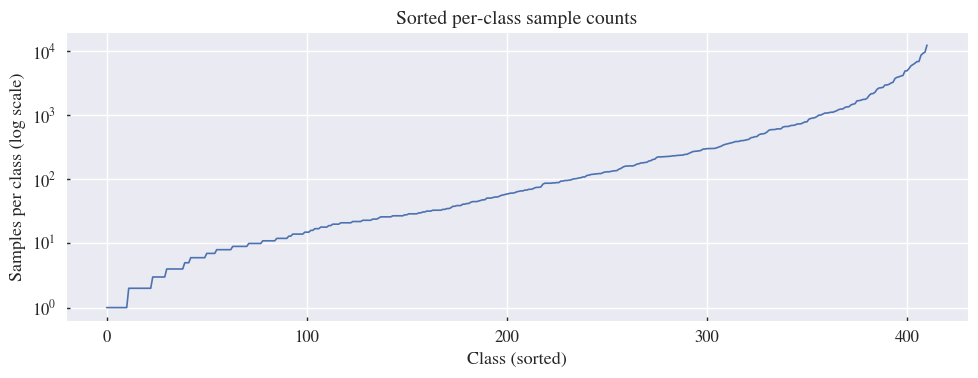

In [9]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [10]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

/workspace/.venv/lib/python3.10/site-packages/torchmetrics/functional/classification/calibration_error.py:48: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  indices = torch.bucketize(confidences, bin_boundaries, right=True) - 1


Accuracy: tensor(0.9984)
cmAP: tensor(0.3220)
Precision: tensor(0.4748)
Recall: tensor(0.1026)
F1 Score: tensor(0.1409)
AUROC: tensor(0.9812)
ECE: tensor(0.0015)
ECE Weighted: tensor(0.0110)
ECE Top-3: tensor(0.0288)
ECE Top-5: tensor(0.0252)
ECE Top-10: tensor(0.0205)
ECE Top-21: tensor(0.0147)
Miscalibration Score (MCS): tensor(-0.0109)
ECE Under-confidence: tensor(0.0110)
ECE Over-confidence: tensor(7.4169e-05)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = 1.10%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

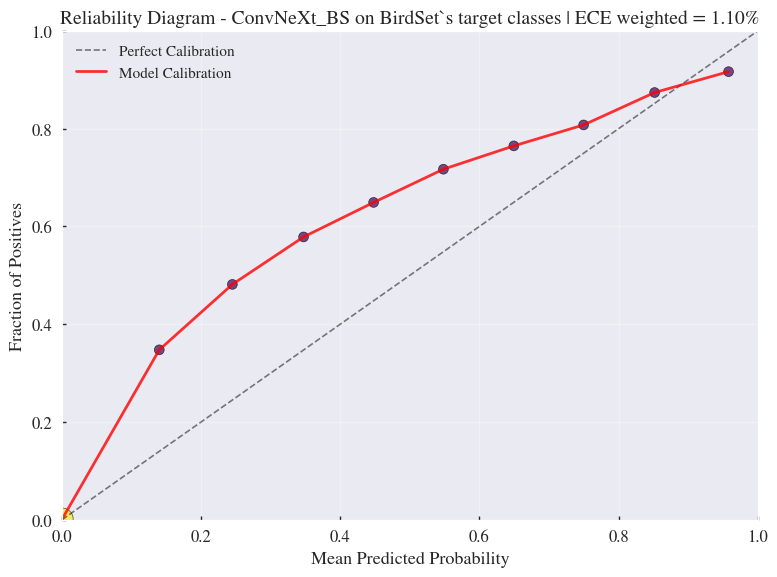

In [11]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [12]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

In [13]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    preds = data[key]["predictions"]
    tar = data[key]["targets"]
    data[key]["metrics"] = print_metrics(preds, tar)

Computing metrics for HSN


/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/workspace/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9988)
cmAP: tensor(0.4872)
Precision: tensor(0.0299)
Recall: tensor(0.0042)
F1 Score: tensor(0.0069)
AUROC: tensor(0.0454)
ECE: tensor(0.0012)
ECE Weighted: tensor(0.1181)
ECE Top-3: tensor(0.1177)
ECE Top-5: tensor(0.0854)
ECE Top-10: tensor(0.0474)
ECE Top-21: tensor(0.0229)
Miscalibration Score (MCS): tensor(-0.1180)
ECE Under-confidence: tensor(0.1180)
ECE Over-confidence: tensor(3.3722e-05)
Computing metrics for NBP
Accuracy: tensor(0.9964)
cmAP: tensor(0.6136)
Precision: tensor(0.0753)
Recall: tensor(0.0211)
F1 Score: tensor(0.0293)
AUROC: tensor(0.1135)
ECE: tensor(0.0033)
ECE Weighted: tensor(0.0328)
ECE Top-3: tensor(0.0565)
ECE Top-5: tensor(0.0524)
ECE Top-10: tensor(0.0465)
ECE Top-21: tensor(0.0412)
Miscalibration Score (MCS): tensor(-0.0323)
ECE Under-confidence: tensor(0.0326)
ECE Over-confidence: tensor(0.0002)
Computing metrics for NES
Accuracy: tensor(0.9990)
cmAP: tensor(0.3414)
Precision: tensor(0.0941)
Recall: tensor(0.0318)
F1 Score: tensor(0.04

### Reliability Diagram
```

#### Combined

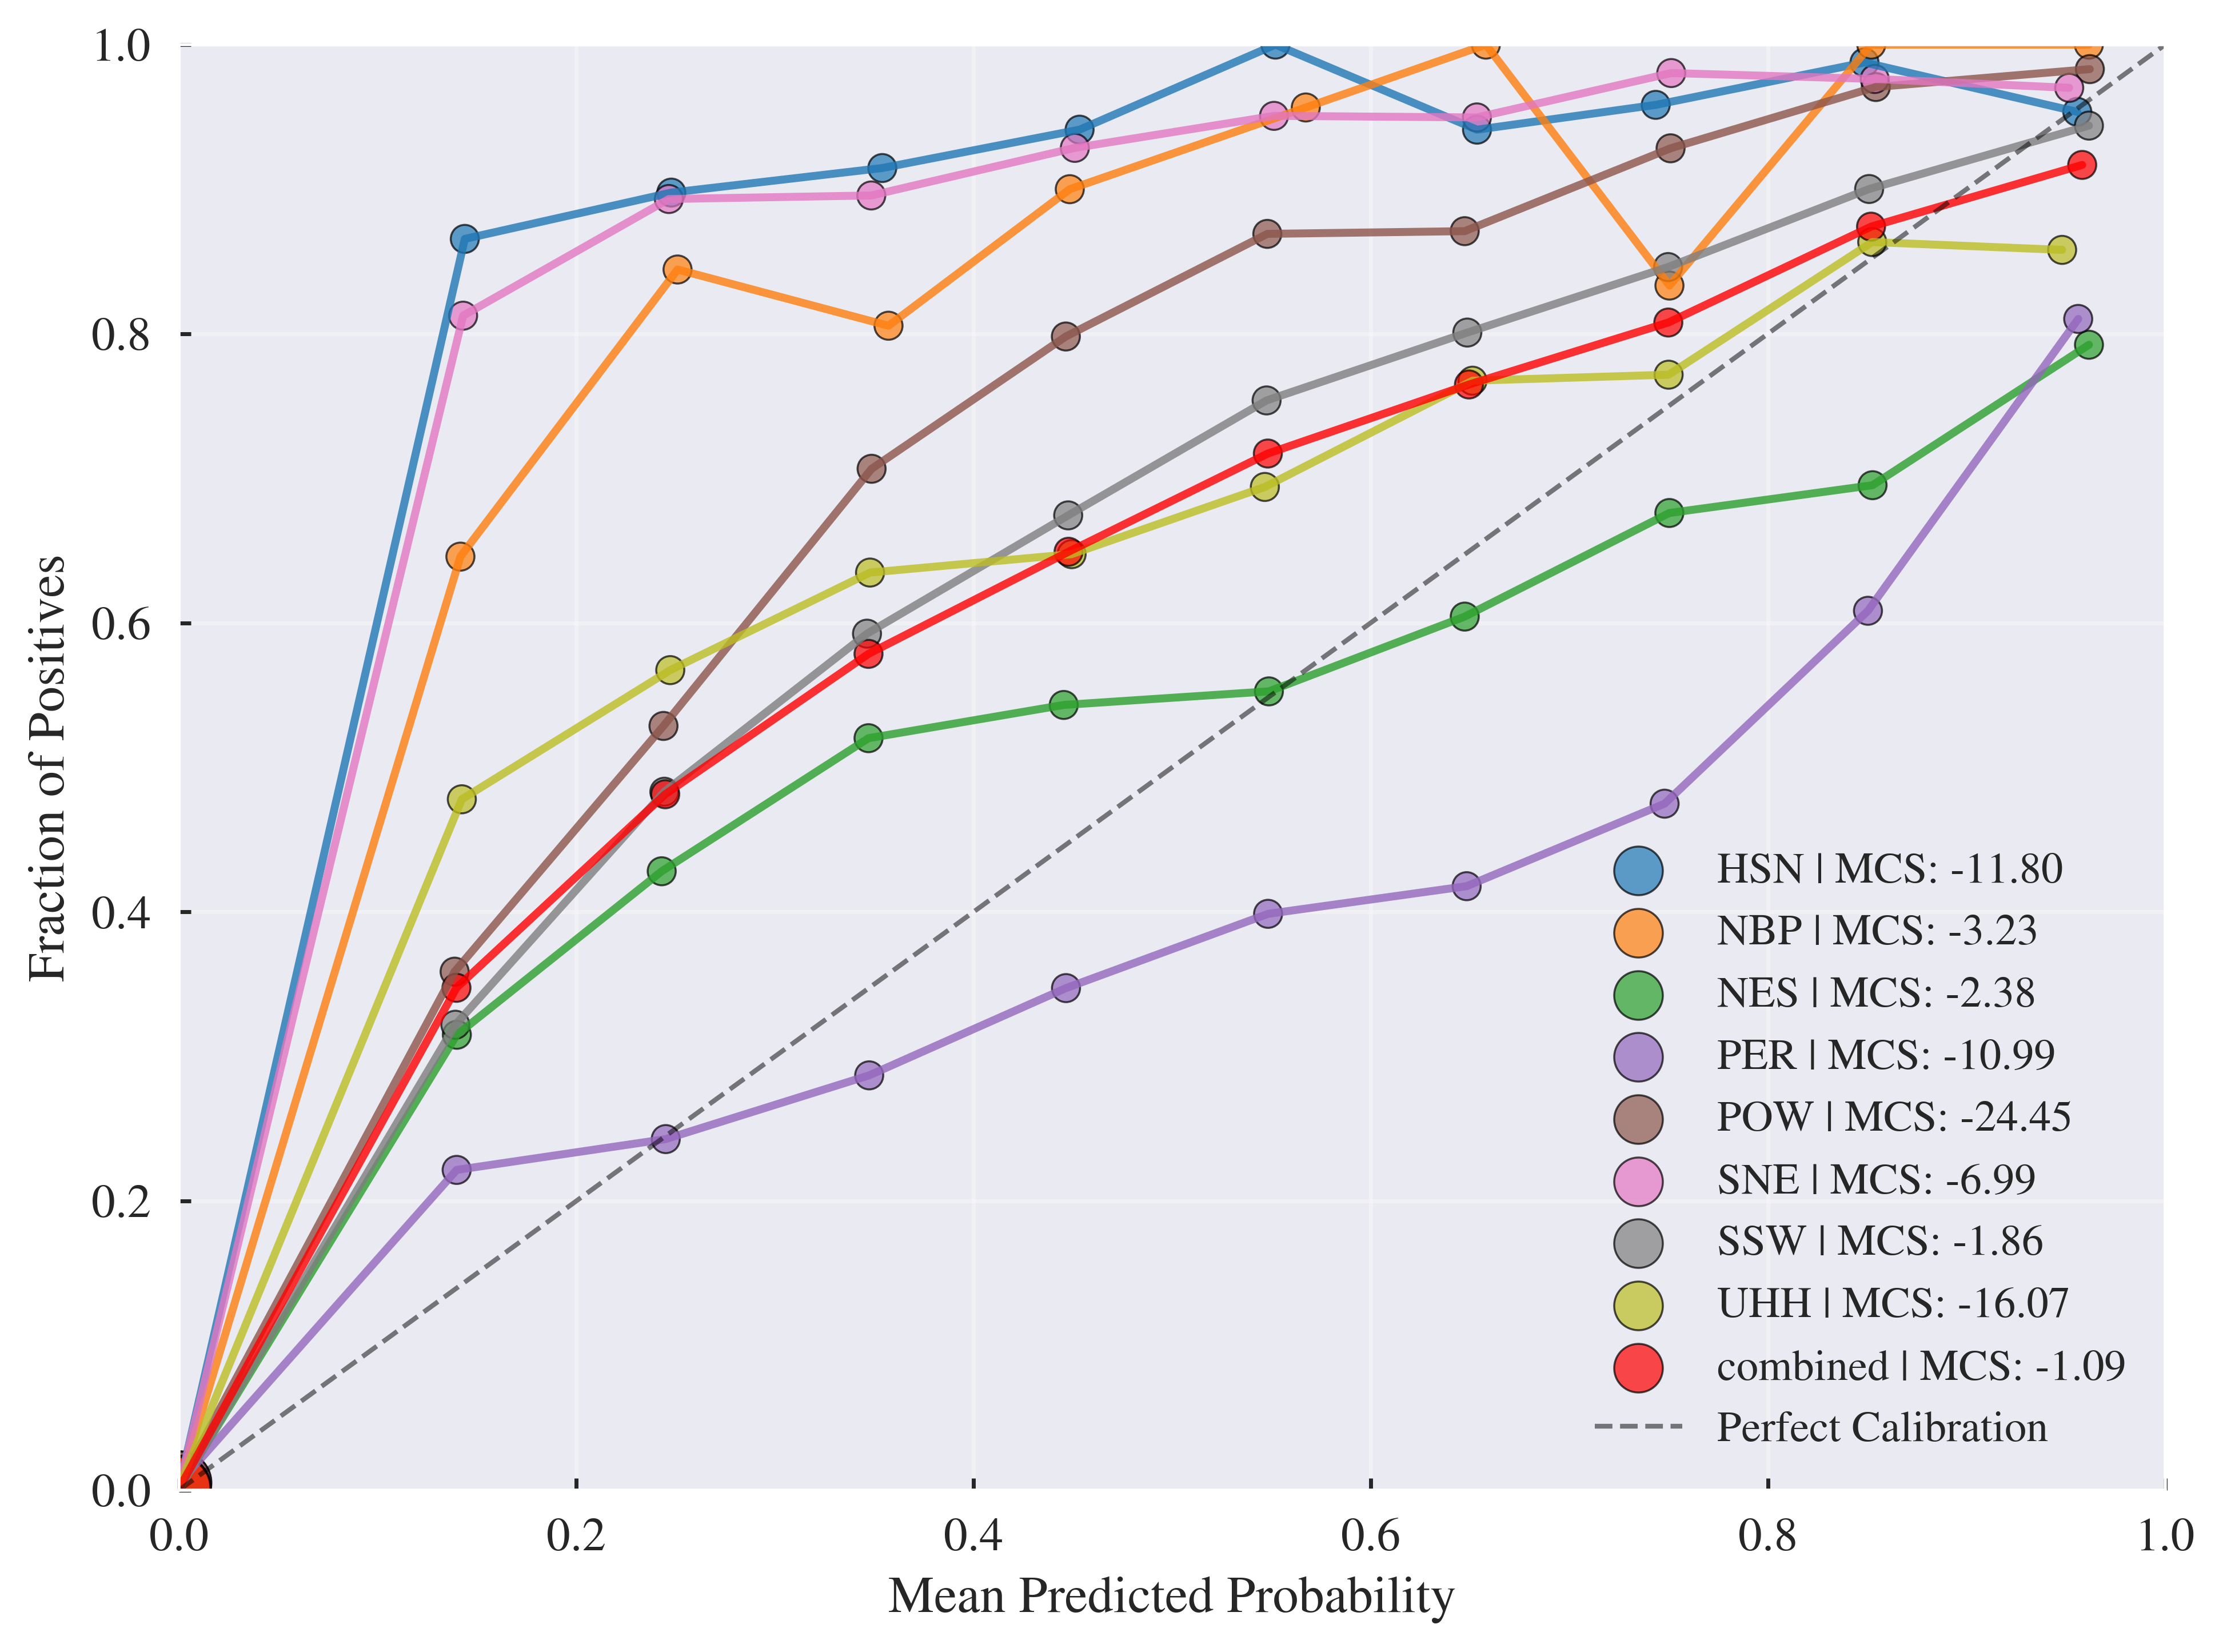

In [15]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}
ax = plot_combined_reliability_diagram(
    data, n_bins=10, title=""
)
plt.savefig(
    "/workspace/uncertainbird/results/convnext_bs_reliability_diagram.pdf", bbox_inches="tight", pad_inches=0.01
)

#### Per class

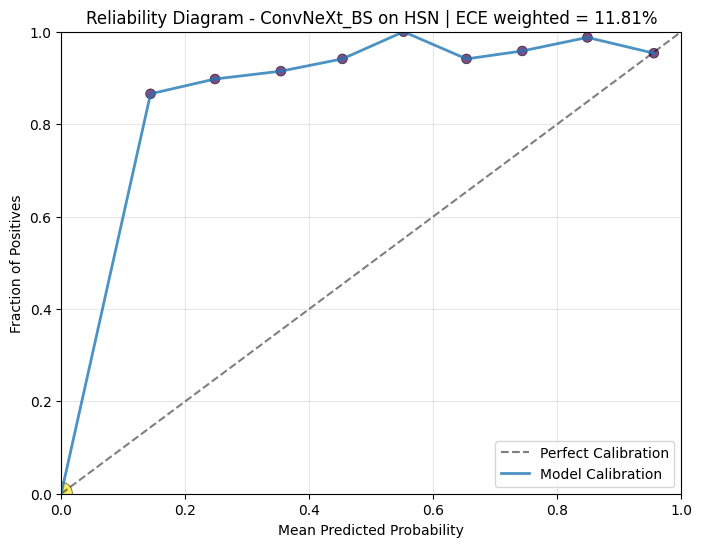

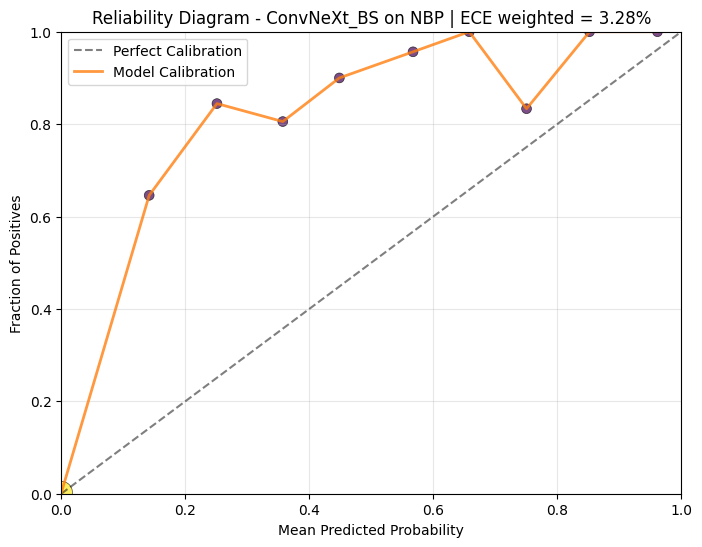

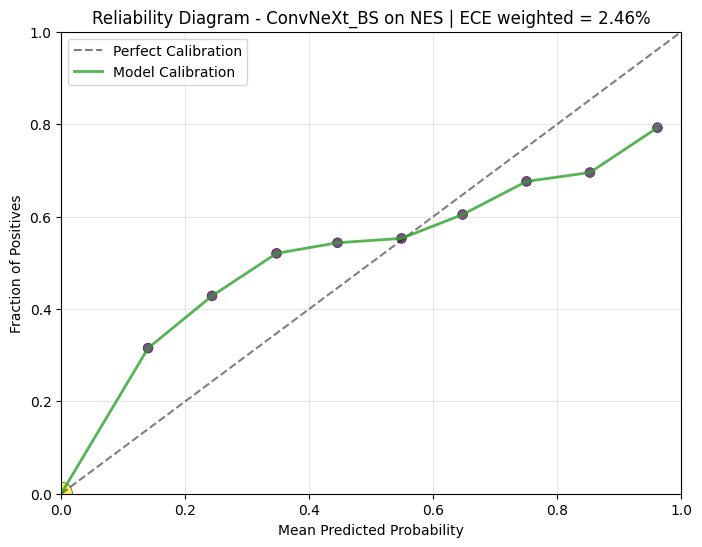

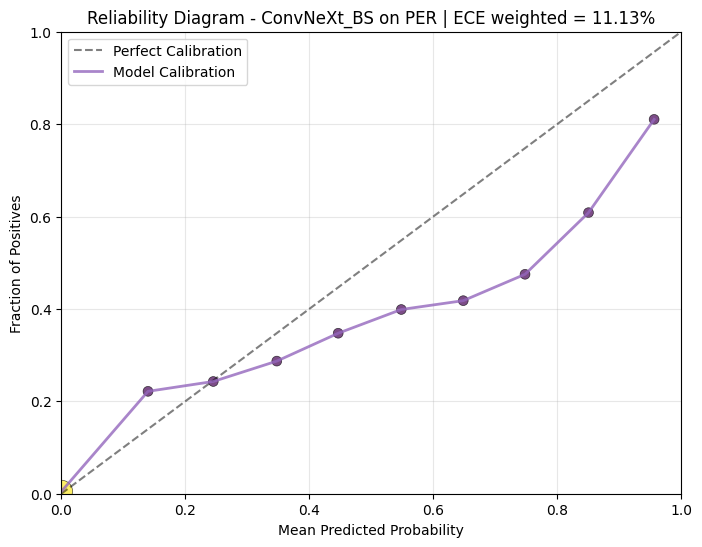

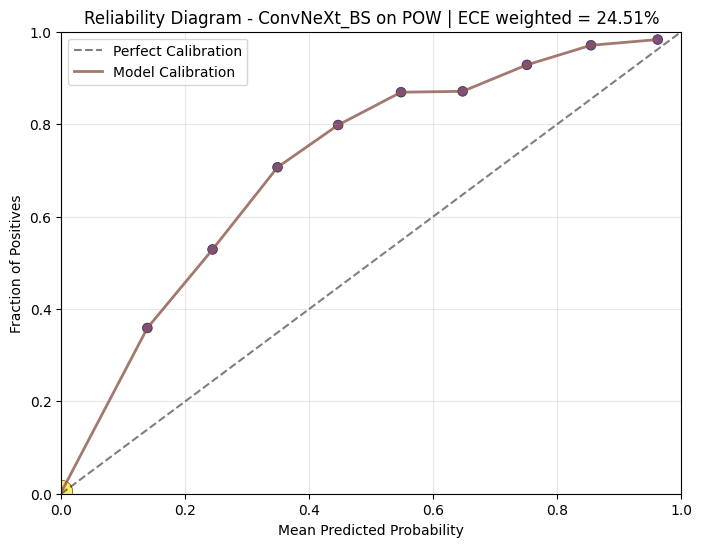

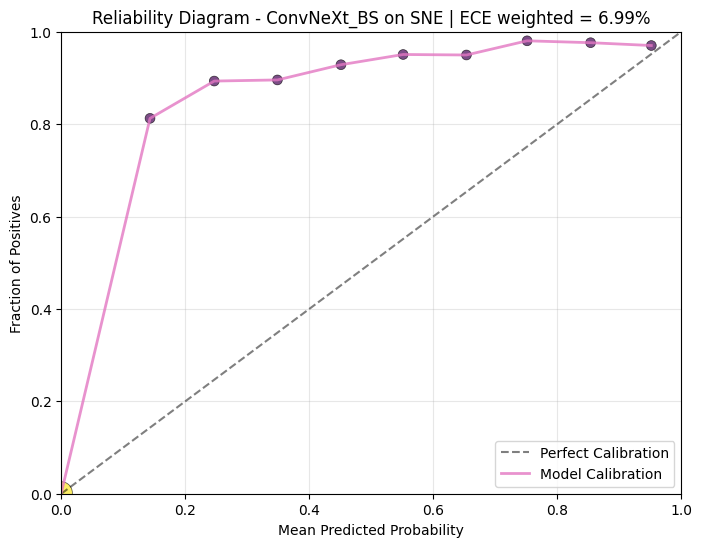

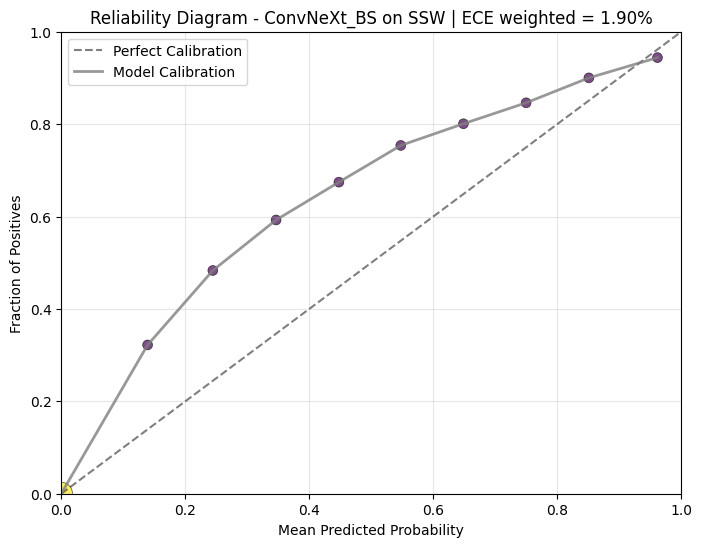

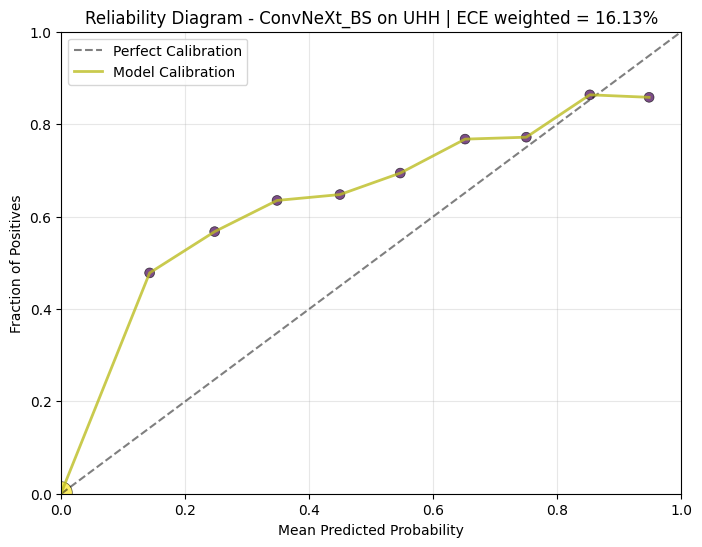

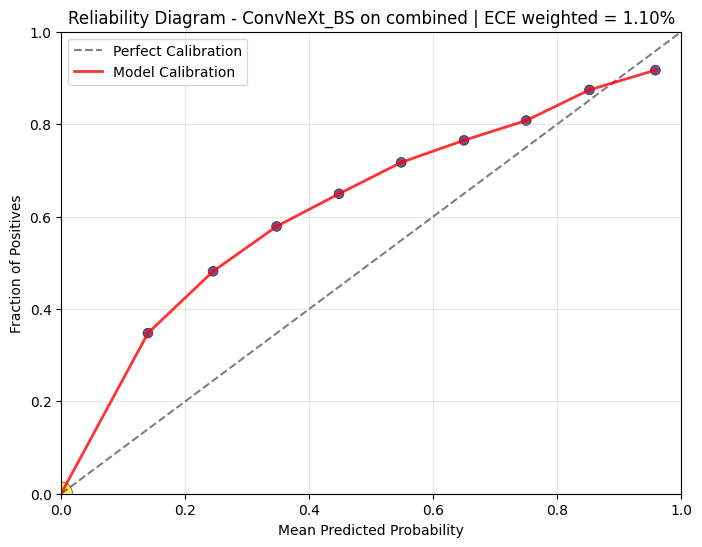

In [28]:
for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [29]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

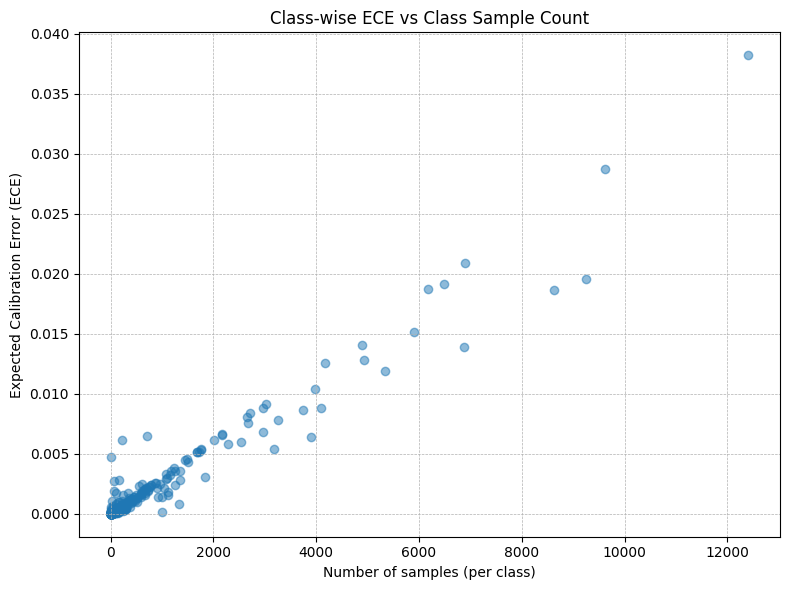

In [30]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

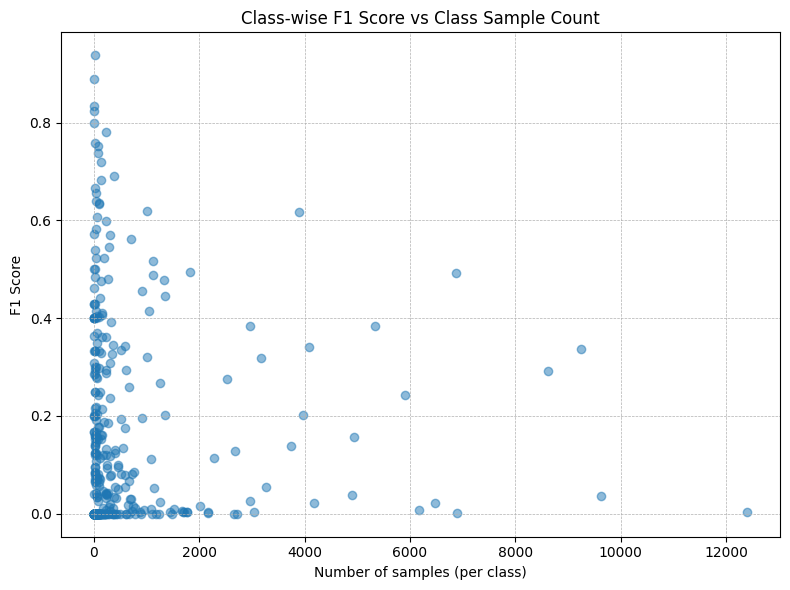

In [31]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

In [32]:
# print cmAP for each dataset in the format "Dataset: <name>, cmAP: <value>"
print("cmAP per dataset:")
for key in data:
    print(f"Dataset: {key}, cmAP: {data[key]['metrics']['cmAP']*100:.2f}")

print("ECE for each dataset:")
for key in data:
    print(f"Dataset: {key}, ece: {data[key]['metrics']['ece_weighted']*100:.2f}")
print("MCS for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['mcs']*100:.2f}")
print("Under confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_under']*100:.2f}")
print("Over confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_over']*100:.2f}")

cmAP per dataset:
Dataset: HSN, cmAP: 48.72
Dataset: NBP, cmAP: 61.36
Dataset: NES, cmAP: 34.14
Dataset: PER, cmAP: 17.60
Dataset: POW, cmAP: 33.99
Dataset: SNE, cmAP: 30.05
Dataset: SSW, cmAP: 34.79
Dataset: UHH, cmAP: 24.72
Dataset: combined, cmAP: 32.20
ECE for each dataset:
Dataset: HSN, ece: 11.81
Dataset: NBP, ece: 3.28
Dataset: NES, ece: 2.46
Dataset: PER, ece: 11.13
Dataset: POW, ece: 24.51
Dataset: SNE, ece: 6.99
Dataset: SSW, ece: 1.90
Dataset: UHH, ece: 16.13
Dataset: combined, ece: 1.10
MCS for each dataset:
Dataset: HSN, mcs: -11.80
Dataset: NBP, mcs: -3.23
Dataset: NES, mcs: -2.38
Dataset: PER, mcs: -10.99
Dataset: POW, mcs: -24.45
Dataset: SNE, mcs: -6.99
Dataset: SSW, mcs: -1.86
Dataset: UHH, mcs: -16.07
Dataset: combined, mcs: -1.09
Under confidence score for each dataset:
Dataset: HSN, mcs: 11.80
Dataset: NBP, mcs: 3.26
Dataset: NES, mcs: 2.42
Dataset: PER, mcs: 11.06
Dataset: POW, mcs: 24.48
Dataset: SNE, mcs: 6.99
Dataset: SSW, mcs: 1.88
Dataset: UHH, mcs: 16.10
Dat